# Heat Flux Based Reconstruction of Freestream Conditions in Atmospheric Reentry Flows

__A. Cortesi__, INRIA

__P. Constantine__, Colorado School of Mines, <pconstan@mines.edu>

__T. Magin__, von Karman Institute for Fluid Dynamics

__P. Congedo__, INRIA

__R. Howard__, Colorado School of Mines, <ryhoward@mines.edu>

<br>

In this notebook, we'll be summarizing the active subspaces results on a model of atmospheric reentry of a space vehicle, presented in [1].

### Introduction

Analysis of the reentry of space vehicles relies on knowledge of freestream conditions, such as pressure and mach number ahead of the vehicle. These quantities can't be directly measured, but can be reconstructed from measurements of such quantities as stagnation pressure and heat flux on the vehicle's surface. Here, we apply the technique of _active subspaces_ to a model of atmospheric reentry to try to find low-dimensional subspaces of input parameters that accurately characterize model outputs.

### Active Subspaces

Consider a model's scalar-valued output, $f$, as a function of normalized input parameters, $\mathbf x\in R^m$: $f = f(\mathbf x)$. The active subspace method is based on the matrix

$$
\mathbf C = \int\nabla f(\mathbf x)\nabla f(\mathbf x)^T\rho(\mathbf x)\ d\mathbf x = \mathbf W\Lambda\mathbf W^T,
$$

where $\rho(\mathbf x)$ is a probability density on $\mathbf x$ and $\mathbf W\Lambda\mathbf W^T$ is the eigendecomposition of $\mathbf C$ (with the eigenvalues in descending order). The eigenvalues satisfy the relationship $\lambda_i = \int(\nabla f^T\mathbf w_i)^2\rho\ d\mathbf x$; in words, this means the $i^{th}$ eigenvalue quantifies how much $f$ changes, on average, in the direction defined by the $i^{th}$ eigenvector. If the first $n < m$ eigenvalues are much larger than the last $m-n$, $f$ will be relatively flat in the directions defined by the last $m-n$ eigenvectors. Let $\mathbf W_1$ denote the first $n$ eigenvectors contained in $\mathbf W$. The active subspace is the span of $\mathbf W_1$'s columns and we can approximate $f(\mathbf x)\approx g(\mathbf W_1^T\mathbf x)$ for some $g:R^n\rightarrow R$ (e.g. a response surface trained with many pairs of $\mathbf W_1^T\mathbf x$ and $f(\mathbf x)$).

$\mathbf C$ must be approximated numerically; one method commonly employed is Simple Monte Carlo: draw many samples of $\mathbf x$, compute gradients at each point, and use these to approximate $\mathbf C$. However, we do not have access to gradients for the problem we examine here, so we employ an algorithm that essentially fits a global quadratic surrogate model to approximate gradients. Specifically:
1. Draw $\{\mathbf x_j\}_{j=1}^M$ from $\rho$.
2. Compute $f_j = f(\mathbf x_j)\ \forall j$
3. Use least squares to compute the coefficients $a,\ \mathbf b,$ and $\mathbf H$ of the approximation $f_j \approx a + \mathbf b^T\mathbf x_j + \frac 1 2 \mathbf x_j^T\mathbf H\mathbf x_j$
4. Compute the approximated eigendecomposition: $\mathbf b\mathbf b^T + \mathbf H\left(\int \mathbf x\mathbf x^T\rho\ d\mathbf x\right)\mathbf H^T = \hat{\mathbf W}\hat\Lambda\hat{\mathbf W}^T$ (when the components of $\mathbf x$ are independent, the integral simplifies to the diagonal matrix whose $i^{th}$ element is the variance of the $i^{th}$ component of $\mathbf x$).

### The Reentry Model

We model the hypersonic high-temperature reacting flow around the European Experimental Reentry Test-Bed (EXPERT) vehicle during reentry. The model outputs two quantities of interest: the pressure ($p_{st}$) and heat flux ($q_{st}$) at the stagnation point. The model takes into account fluid flow, chemistry on 5 air species (N, O, NO, N$_2$, and O$_2$), and the catalyticity of the vehicle's surface. There are 7 input parameters, 3 of which are freestream conditions and 4 of which are rates of chemical reactions; these are summarized in the tables below.

Variable | Symbol | Distribution | Minimum | Maximum
:-:|:-:|:-:|:-:|:-:
Freestream Pressure | $p_{\infty}$ | Uniform | 16.3 | 24.3
Freestream Mach Number | $M_{\infty}$ | Uniform | 13.7 | 17.3
Catalytic Recombination Coefficient | $\gamma$ | Uniform | .001 | .002

Gas Reaction | Distribution of $\log_{10}(k_r)$ | $\sigma_r$
:-:|:-:|:-:
NO + O $\rightarrow$ N + O + O | Normal | 0.12
NO + N $\rightarrow$ N + O + N | Normal | 0.12
O$_2$ + N$_2$ $\rightarrow$ 2O + N$_2$ | Normal | 0.10
O$_2$ + O $\rightarrow$ 2O + O | Normal | 0.10

### References

[1] A.F. Cortesi, P.G. Constantine, T.E. Magin, and P.M. Congedo. _Heat flux based reconstruction of freestream conditions in atmospheric reentry flows_.

[[2]][R2] P.G. Constantine, E. Dow, and Q. Wang. _Active subspaces in theory and practice: applications to kriging surfaces_. SIAM J. Sci. Comput., 36(4), A1500–A1524

[R2]: http://dx.doi.org/10.1137/130916138

### Acknowledgments

This material is based upon work supported by the U.S. Department of Energy Office of Science, Office of Advanced Scientific Computing Research, Applied Mathematics program under Award Number DE-SC-0011077.

<br>

We'll now code up the analysis using the [Python Active-subspaces Utility Library](https://github.com/paulcon/active_subspaces).

In [1]:
%matplotlib inline
import numpy as np
import pandas as pn
import active_subspaces as asub
import matplotlib.pyplot as plt

In [2]:
#load the data from its file
df = pn.DataFrame.from_csv('SA_lhs_all.txt')
data = df.as_matrix()

Xu0 = data[:,:3] #uniform inputs
Xn = data[:,3:7] #normal inputs (log reaction rates)

M = Xu0.shape[0] #number of data points
m = Xu0.shape[1] + Xn.shape[1] #number of parameters

pst = data[:,7].reshape((M, 1)) #stagnation pressure
qst = data[:,8].reshape((M, 1)) #stagnation heat flux

#labels for plots
in_labels = [r'$P_{\infty}$', r'$M_{\infty}$', r'$\gamma$', r'log($r_1$)',
            r'log($r_2$)',r'log($r_3$)',r'log($r_4$)']
out_labels = [r'$p_{st}$', r'$q_{st}$']

In [3]:
#bounds for uniform inputs
lb, ub = np.array([16.3, 13.7, 0.001]), np.array([24.3, 17.3, 0.002])
#normalize uniform inputs to the interval [-1, 1]
Xu = asub.utils.misc.BoundedNormalizer(lb, ub).normalize(Xu0)

#normalize normal inputs by dividing by the SD
Xn[:,:2] /= .12; Xn[:,2:] /= .10

In [4]:
#combine normalized uniform and normal inputs
X = np.hstack((Xu, Xn))

#subspace objects for each output
ss_p, ss_q = asub.subspaces.Subspaces(), asub.subspaces.Subspaces()

#compute subspaces
ss_p.compute(X=X, f=pst, sstype='QPHD'); ss_p.partition(2)
ss_q.compute(X=X, f=qst, sstype='QPHD'); ss_q.partition(2)

We plot the estimated eigenvalues, the components of the first 2 eigenvectors, and 1- and 2-dimensional summary plots (plots of the active variable(s), $\mathbf W_1^T\mathbf x$, vs data values). Tight trends in the summary plots indicate exploitable active subspaces.

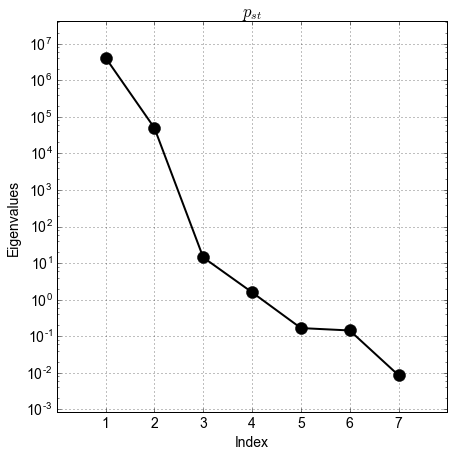

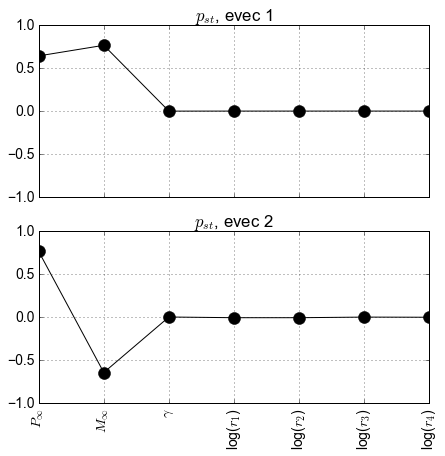

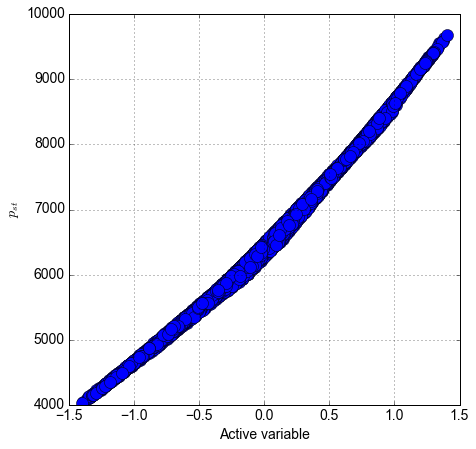

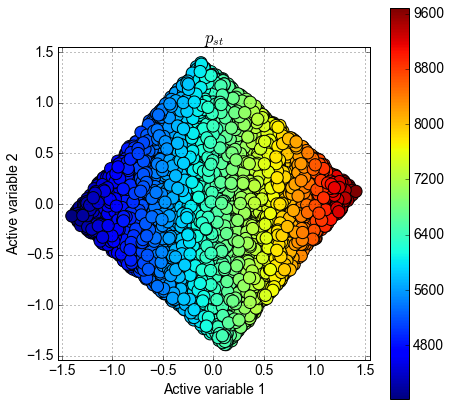

In [5]:
#make plots for stagnation pressure
asub.utils.plotters.eigenvalues(ss_p.eigenvals, out_label=out_labels[0])
asub.utils.plotters.eigenvectors(ss_p.W1, in_labels=in_labels, out_label=out_labels[0])
asub.utils.plotters.sufficient_summary(X.dot(ss_p.W1), pst, out_label=out_labels[0])

We can see the second eigenvalue is an order of magnitude smaller than the first and the remaining eigenvalues are many orders smaller than the first 2, so we would expect 1- and 2-dimensional subspaces. These are seen in the summary plots, which reveal nearly perfect trends in one or two active variables. The eigenvectors provide a measure of global sensitivity; higher-magnitude components indicate more sensitivity to the corresponding parameter. Both eigenvectors place all their weight on the freestream conditions; no weight is placed on $\gamma$ or the reaction rates, indicating that they do not influence $p_{st}$.

We now show the same plots for $q_{st}$.

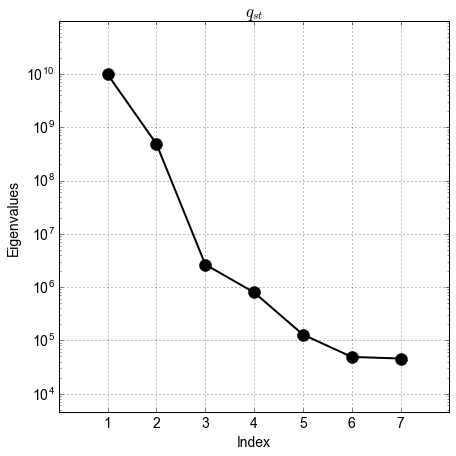

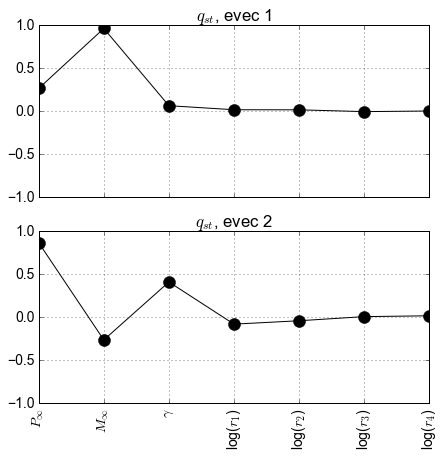

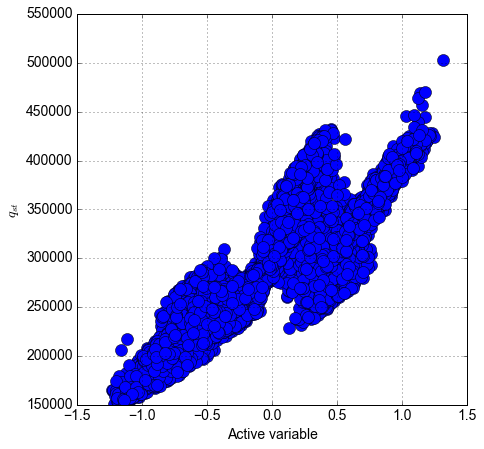

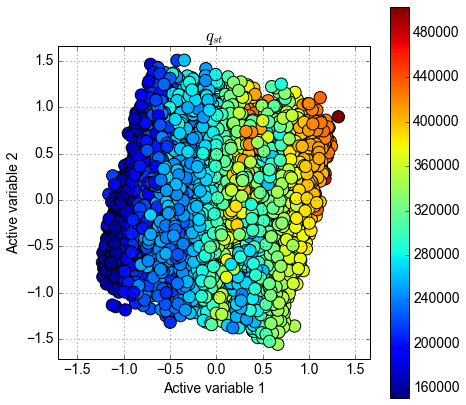

In [6]:
#make plots for stagnation heat flux
asub.utils.plotters.eigenvalues(ss_q.eigenvals, out_label=out_labels[1])
asub.utils.plotters.eigenvectors(ss_q.W1, in_labels=in_labels, out_label=out_labels[1])
asub.utils.plotters.sufficient_summary(X.dot(ss_q.W1), qst, out_label=out_labels[1])

While we do see some eigenvalue decay, it is not nearly as pronounced as with $p_{st}$. This is reflected in the summary plots, which show some trends, but which are not nearly as tight as with $p_{st}$. The first two eigenvectors again place most of their weight on freestream conditions; neither places appreciable weight on reaction rates and only the second has appreciable weight on $\gamma$. However, $\gamma$ and the reaction rates could play an important role in later eigenvectors, which are the directions in which deviations from the 1- and 2-dimensional trends are explained.

The extremely tight trend for $p_{st}$ could be exploited in the inverse problem, i.e., estimating freestream conditions given measurements of $p_{st}$. With a measurement of $p_{st}$, one could find the (small) range of active variable values allowing for this observation and invert the map from inputs to active variables to find regions of the input space corresponding to this range of active variable values. This information could be combined with other methods to efficiently solve the inverse problem. The significant deviation from the trends in the case of $q_{st}$ makes it unsuitable for this kind of analysis; one would have to rely on inversion methods in the full input space to take advantage of measurements of $q_{st}$.